In [2]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [3]:
from aislens.config import config

In [2]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
DIR_interim = 'data/interim/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'


In [21]:
# ISMIP6 protocol with thermal forcing
ds_ismip6_ySMB = xr.open_dataset(main_dir / DIR_interim / "ismip6-8km-orig-relax/globalStats.nc")
ds_ismip6_meanSatObs_ySMB = xr.open_dataset(main_dir / DIR_interim / "ismip6-8km/globalStats.nc")

ds_meanSatObs_nSMB = xr.open_dataset(main_dir / DIR_interim / "meanSatObsForcing_8km_noSMB/ctrlAE_08/globalStats.nc")
ds_meanSatObs_ySMB = xr.open_dataset(main_dir / DIR_interim / "meanSatObsForcing_8km/ctrlAE_08/globalStats.nc")

In [3]:
# Control simulations: meanBMB forcings
ds_meanBMB_Paolo23 = xr.open_dataset(main_dir / DIR_interim / "meanObsBMB-Paolo2023/globalStats.nc")
ds_meanBMB_Rignot13 = xr.open_dataset(main_dir / DIR_interim / "meanObsBMB-Rignot2013/globalStats.nc")

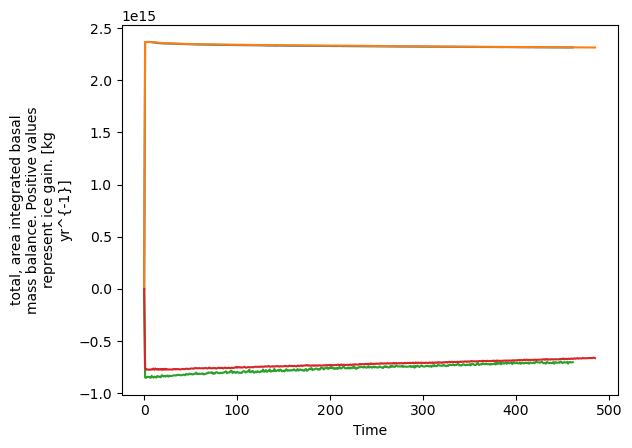

In [7]:
ds_meanBMB_Paolo23.totalSfcMassBal.plot()
ds_meanBMB_Rignot13.totalSfcMassBal.plot()


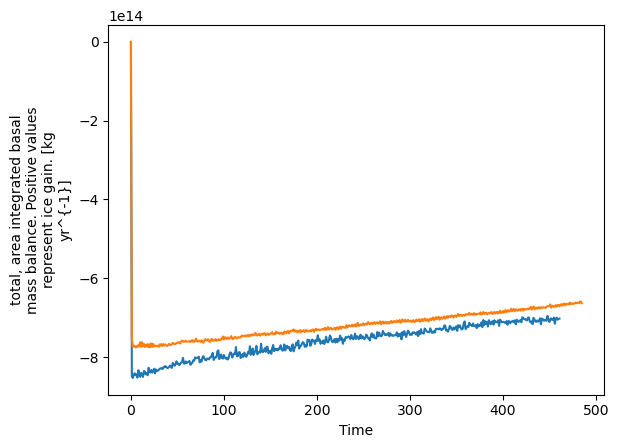

In [8]:
ds_meanBMB_Paolo23.totalBasalMassBal.plot()
ds_meanBMB_Rignot13.totalBasalMassBal.plot()

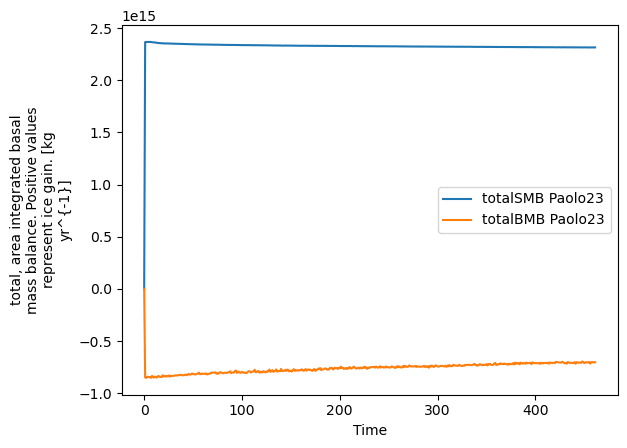

In [26]:

ds_meanBMB_Paolo23.totalSfcMassBal.plot(label= 'totalSMB Paolo23')
ds_meanBMB_Paolo23.totalBasalMassBal.plot(label = 'totalBMB Paolo23')
#ds_meanBMB_Paolo23.totalFloatingBasalMassBal.plot()
#ds_meanBMB_Paolo23.totalGroundedBasalMassBal.plot()
#ds_meanBMB_Paolo23.totalFloatingSfcMassBal.plot()
#ds_meanBMB_Paolo23.totalGroundedBasalMassBal.plot()
#ds_meanBMB_Paolo23.totalGroundedSfcMassBal.plot()
plt.legend()

In [15]:
ds_meanBMB_Rignot13

<xarray.Dataset>
Dimensions:                     (Time: 486)
Dimensions without coordinates: Time
Data variables: (12/32)
    xtime                       (Time) |S64 ...
    simulationStartTime         |S64 ...
    daysSinceStart              (Time) timedelta64[ns] ...
    deltat                      (Time) float64 ...
    allowableDtACFL             (Time) float64 ...
    allowableDtDCFL             (Time) float64 ...
    ...                          ...
    totalCalvingFlux            (Time) float64 ...
    totalFaceMeltingFlux        (Time) float64 ...
    groundingLineFlux           (Time) float64 ...
    groundingLineMigrationFlux  (Time) float64 ...
    surfaceSpeedMax             (Time) float64 ...
    basalSpeedMax               (Time) float64 ...
Attributes: (12/185)
    model_name:                                             mpas
    core_name:                                              landice
    source:                                                 MPAS
    Conventions:                                            MPAS
    git_version:                                            v2.0.0-beta.3-306...
    on_a_sphere:                                            NO
    ...                                                     ...
    config_AM_regionalStats_enable:                         YES
    config_AM_regionalStats_compute_interval:               output_interval
    config_AM_regionalStats_stream_name:                    regionalStatsOutput
    config_AM_regionalStats_compute_on_startup:             YES
    config_AM_regionalStats_write_on_startup:               YES
    file_id:                                                nniu3n9jhr

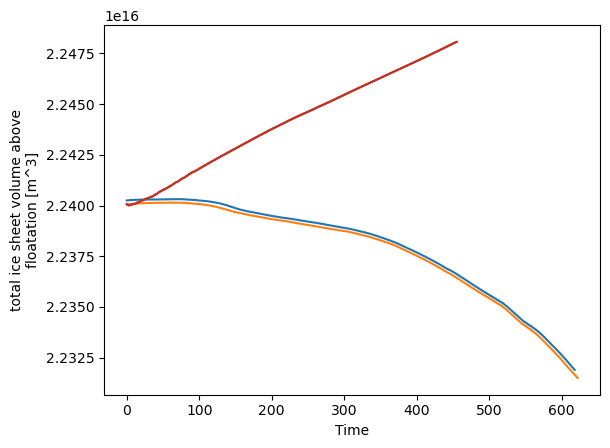

In [23]:
#plt.figure(25,8)

ds_ismip6_ySMB.volumeAboveFloatation.plot()
ds_ismip6_meanSatObs_ySMB.volumeAboveFloatation.plot()
ds_meanSatObs_ySMB.volumeAboveFloatation.plot()
ds_meanSatObs_nSMB.volumeAboveFloatation.plot()

In [24]:
ctrl = ds_meanSatObs_nSMB

In [25]:
ctrl.data_vars

Data variables:
    xtime                       (Time) |S64 ...
    simulationStartTime         |S64 ...
    daysSinceStart              (Time) timedelta64[ns] ...
    deltat                      (Time) float64 ...
    allowableDtACFL             (Time) float64 ...
    allowableDtDCFL             (Time) float64 ...
    albanyVelocityError         (Time) int32 ...
    totalIceVolume              (Time) float64 ...
    volumeAboveFloatation       (Time) float64 ...
    totalIceArea                (Time) float64 ...
    floatingIceVolume           (Time) float64 ...
    floatingIceArea             (Time) float64 ...
    groundedIceVolume           (Time) float64 ...
    groundedIceArea             (Time) float64 ...
    iceThicknessMean            (Time) float64 ...
    iceThicknessMax             (Time) float64 ...
    iceThicknessMin             (Time) float64 ...
    totalSfcMassBal             (Time) float64 ...
    totalGroundedSfcMassBal     (Time) float64 ...
    totalFloatingSfcMa

In [3]:
config.DIR_MALI

PosixPath('/Users/smurugan9/research/aislens/AISLENS/data/MALI')

# Output flux and output state

In [64]:
satobs = xr.open_dataset(config.FILE_PAOLO23_SATOBS)

In [66]:
satobs_tm = satobs.mean(dim='Time')

In [59]:
experiment = "ENSEMBLES/CTRL/CTRL-EM-NO-BMB-ADJ-5PARAM"

outputflux = xr.open_dataset(config.DIR_MALI / experiment / "output_flux_all_timesteps_2000.nc")
outputstate = xr.open_dataset(config.DIR_MALI / experiment / "output_state_2000.nc")

draft = outputstate['lowerSurface']
bedtopo = outputstate['bedTopography']
floatingBMB = outputflux['floatingBasalMassBalApplied']

draft_tm = draft.mean(dim='Time')
floatingBMB_tm = floatingBMB.mean(dim='Time')

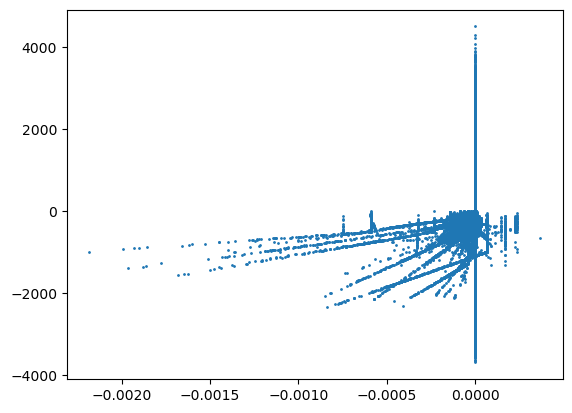

In [60]:
plt.scatter(floatingBMB_tm, draft_tm, s=1)

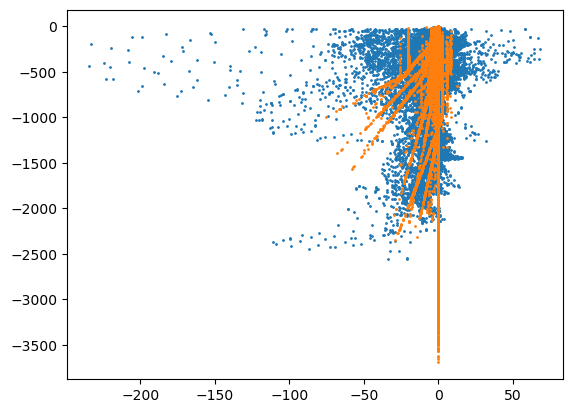

In [82]:
# plot the above scatter plot only for points where draft_tm > 0
plt.scatter(satobs_tm_melt*(365*24*3600/910), -satobs_tm.draft, s=1)
plt.scatter(floatingBMB_tm.where(draft_tm < 0)*(365*24*3600/910), draft_tm.where(draft_tm < 0), s=1)
#plt.xlim(-0.0005,0)

In [77]:
satobs_tm_melt = satobs_tm.melt*910/(365*24*3600)

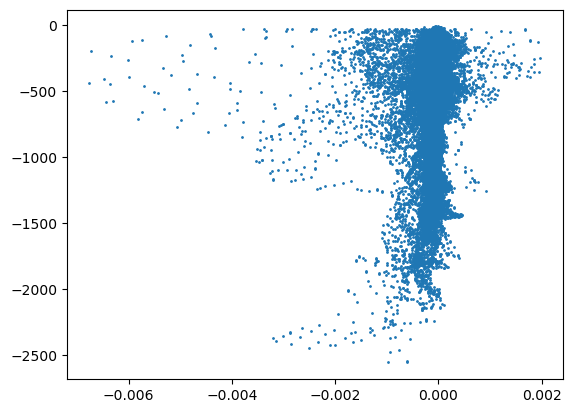

In [24]:
# Use icems masks to plot this for specific ice shelves
icems = gpd.read_file(config.FILE_ICESHELFMASKS);

In [31]:
from aislens.geospatial import clip_data

In [32]:
from aislens.dataprep import write_crs

In [ ]:
floatingBMB_tm = write_crs(floatingBMB_tm)


MissingSpatialDimensionError: y dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'y' can address this. Data variable: floatingBasalMassBalApplied